<a href="https://colab.research.google.com/github/audalsgh/20250707/blob/main/0707_python_tensorflow%2C_K_means_%ED%81%B4%EB%9F%AC%EC%8A%A4%ED%84%B0%EB%A7%81_%EC%82%AC%EC%9A%A9_%EC%98%88%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install opencv-python tensorflow scikit-learn matplotlib pillow
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import os
from PIL import Image

class AutonomousDrivingMLSystem:
    def __init__(self):
        self.lane_detector = None
        self.traffic_sign_classifier = None
        self.speed_predictor = None

    def preprocess_image(self, image_path):
        """이미지 전처리 함수"""
        image = cv2.imread(image_path)
        if image is None:
            return None

        # 크기 조정
        image = cv2.resize(image, (224, 224))
        # 정규화
        image = image.astype(np.float32) / 255.0
        return image

    def detect_lane_features(self, image):
        """차선 특징 추출"""
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # 가우시안 블러 적용
        blur = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blur, 50, 150)

        # 관심 영역 설정 (도로 하단부)
        height = edges.shape[0]
        mask = np.zeros_like(edges)
        polygon = np.array([[
            (0, height),
            (edges.shape[1], height),
            (edges.shape[1], height//2),
            (0, height//2)
        ]], np.int32)
        cv2.fillPoly(mask, polygon, 255)
        masked_edges = cv2.bitwise_and(edges, mask)

        # 허프 변환으로 직선 검출
        lines = cv2.HoughLinesP(masked_edges, 1, np.pi/180,
                               threshold=50, minLineLength=100, maxLineGap=50)

        features = []
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                # 기울기와 길이 계산
                if x2 - x1 != 0:
                    slope = (y2 - y1) / (x2 - x1)
                    length = np.sqrt((x2-x1)**2 + (y2-y1)**2)
                    features.extend([slope, length, x1, y1, x2, y2])

        # 고정 길이로 맞추기
        while len(features) < 30:
            features.append(0)
        return features[:30]

    def build_traffic_sign_cnn(self):
        """교통 표지판 분류를 위한 CNN 모델"""
        model = models.Sequential([
            layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.MaxPooling2D((2, 2)),
            layers.Conv2D(64, (3, 3), activation='relu'),
            layers.Flatten(),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(4, activation='softmax')  # 4개 클래스: 정지, 직진, 좌회전, 우회전
        ])

        model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
        return model

    def generate_sample_data(self):
        """샘플 데이터 생성 (실제로는 실제 도로 이미지를 사용)"""
        # 차선 특징 데이터 생성
        np.random.seed(42)
        lane_features = []
        lane_decisions = []

        for i in range(1000):
            # 30개 특징 (기울기, 길이, 좌표 등)
            features = np.random.randn(30)

            # 차선 중앙 유지 여부 결정 (0: 좌회전, 1: 직진, 2: 우회전)
            if features[0] < -0.5:  # 왼쪽 기울기가 강함
                decision = 0  # 우회전으로 보정
            elif features[0] > 0.5:  # 오른쪽 기울기가 강함
                decision = 2  # 좌회전으로 보정
            else:
                decision = 1  # 직진

            lane_features.append(features)
            lane_decisions.append(decision)

        # 교통 표지판 이미지 데이터 생성 (실제로는 실제 표지판 이미지)
        sign_images = np.random.rand(500, 64, 64, 3)
        sign_labels = np.random.randint(0, 4, 500)

        return np.array(lane_features), np.array(lane_decisions), sign_images, sign_labels

    def train_lane_keeping_system(self):
        """차선 유지 시스템 훈련"""
        print("차선 유지 시스템 훈련 시작...")

        # 샘플 데이터 생성
        lane_features, lane_decisions, _, _ = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            lane_features, lane_decisions, test_size=0.2, random_state=42
        )

        # 랜덤 포레스트 분류기 훈련
        self.lane_detector = RandomForestClassifier(n_estimators=100, random_state=42)
        self.lane_detector.fit(X_train, y_train)

        # 성능 평가
        y_pred = self.lane_detector.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)

        print(f"차선 유지 시스템 정확도: {accuracy:.3f}")
        print("\n분류 보고서:")
        print(classification_report(y_test, y_pred,
                                   target_names=['좌회전', '직진', '우회전']))

        return accuracy

    def train_traffic_sign_classifier(self):
        """교통 표지판 분류기 훈련"""
        print("\n교통 표지판 분류기 훈련 시작...")

        # 샘플 데이터 생성
        _, _, sign_images, sign_labels = self.generate_sample_data()

        # 훈련/테스트 데이터 분할
        X_train, X_test, y_train, y_test = train_test_split(
            sign_images, sign_labels, test_size=0.2, random_state=42
        )

        # CNN 모델 생성 및 훈련
        self.traffic_sign_classifier = self.build_traffic_sign_cnn()

        history = self.traffic_sign_classifier.fit(
            X_train, y_train,
            epochs=10,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=1
        )

        # 성능 평가
        test_loss, test_accuracy = self.traffic_sign_classifier.evaluate(X_test, y_test, verbose=0)
        print(f"\n교통 표지판 분류 정확도: {test_accuracy:.3f}")

        return test_accuracy

    def predict_driving_action(self, image_path):
        """주행 행동 예측"""
        if not os.path.exists(image_path):
            print("이미지 파일을 찾을 수 없습니다.")
            return None

        # 이미지 전처리
        image = self.preprocess_image(image_path)
        if image is None:
            return None

        # 차선 특징 추출
        lane_features = self.detect_lane_features((image * 255).astype(np.uint8))

        # 차선 기반 주행 방향 예측
        if self.lane_detector:
            lane_decision = self.lane_detector.predict([lane_features])[0]
            lane_actions = ['좌회전', '직진', '우회전']

            print(f"차선 분석 결과: {lane_actions[lane_decision]}")

        # 교통 표지판 분류 (64x64 크기로 조정)
        if self.traffic_sign_classifier:
            sign_image = cv2.resize((image * 255).astype(np.uint8), (64, 64))
            sign_image = np.expand_dims(sign_image.astype(np.float32) / 255.0, axis=0)

            sign_prediction = self.traffic_sign_classifier.predict(sign_image, verbose=0)
            sign_class = np.argmax(sign_prediction[0])
            sign_confidence = np.max(sign_prediction[0])

            sign_names = ['정지', '직진', '좌회전', '우회전']
            print(f"교통표지판 인식: {sign_names[sign_class]} (신뢰도: {sign_confidence:.3f})")

        return lane_decision if self.lane_detector else None

def main():
    """메인 실행 함수"""
    print("=== 자율주행 지도학습 시스템 ===\n")

    # 시스템 초기화
    autonomous_system = AutonomousDrivingMLSystem()

    # 모델 훈련
    lane_accuracy = autonomous_system.train_lane_keeping_system()
    sign_accuracy = autonomous_system.train_traffic_sign_classifier()

    print(f"\n=== 훈련 완료 ===")
    print(f"차선 유지 시스템 정확도: {lane_accuracy:.1%}")
    print(f"교통표지판 분류 정확도: {sign_accuracy:.1%}")

    # 샘플 이미지로 테스트 (실제 파일이 있다면)
    # test_image = "sample_road.jpg"
    # result = autonomous_system.predict_driving_action(test_image)

if __name__ == "__main__":
    main()

=== 자율주행 지도학습 시스템 ===

차선 유지 시스템 훈련 시작...
차선 유지 시스템 정확도: 1.000

분류 보고서:
              precision    recall  f1-score   support

         좌회전       1.00      1.00      1.00        69
          직진       1.00      1.00      1.00        72
         우회전       1.00      1.00      1.00        59

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200


교통 표지판 분류기 훈련 시작...
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 178ms/step - accuracy: 0.2209 - loss: 1.4164 - val_accuracy: 0.2800 - val_loss: 1.3848
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2875 - loss: 1.3831 - val_accuracy: 0.2400 - val_loss: 1.3868
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2912 - loss: 1.3860 - val_accuracy: 0.2400 - val_loss: 1.3885
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2602 - loss: 1.3824 - val_accuracy: 0.2300 - val_loss: 1.3867
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2441 - loss: 1.3855 - val_accuracy: 0.2200 - val_loss: 1.3872
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2830 - loss: 1.3817 - val_accuracy: 0.2200 - val_loss: 1.3945
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2616 - loss: 1.3897 - val_accuracy: 0.2200 - val_loss: 1.3872
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2889 - loss: 1.3807 - val_accuracy: 0.2200 - val_loss: 1

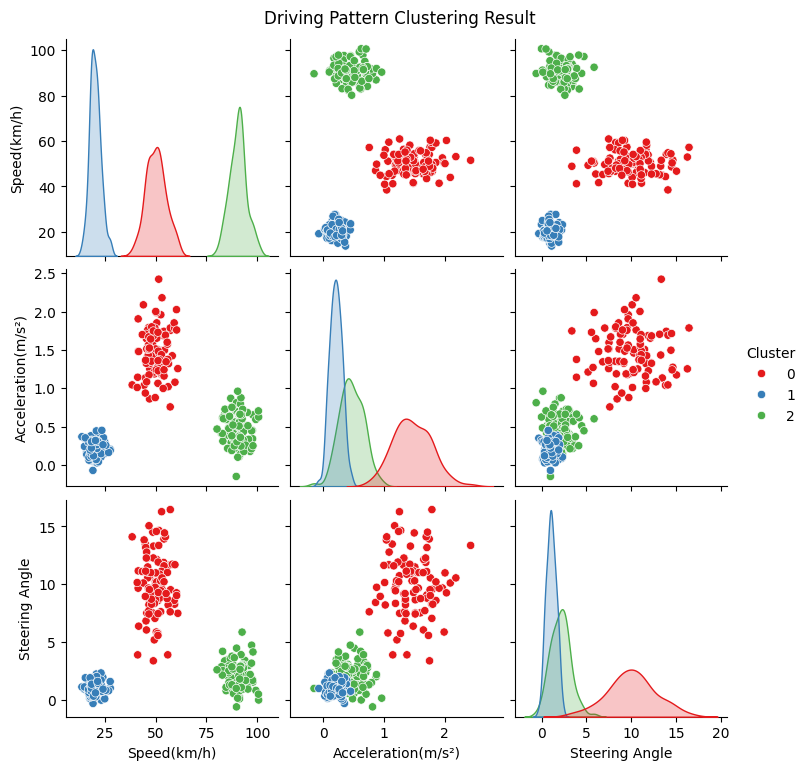

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# 샘플 자율주행 데이터 생성
np.random.seed(42)
n_samples = 300

# # 고속도로 주행 데이터
# 속도 평균 90km/h, 가속도 낮음(0.5), 핸들 조작 작음(2도)
# 고속도로에서 비교적 일직선, 빠른 주행 특징
highway = np.random.normal(loc=[90, 0.5, 2], scale=[5, 0.2, 1], size=(100, 3))

#비슷하게 city(도심), traffic(정체) 데이터도 생성합니다:
city = np.random.normal(loc=[50, 1.5, 10], scale=[5, 0.3, 3], size=(100, 3))
traffic = np.random.normal(loc=[20, 0.2, 1], scale=[3, 0.1, 0.5], size=(100, 3))

data = np.vstack((highway, city, traffic))
df = pd.DataFrame(data, columns=['Speed(km/h)', 'Acceleration(m/s²)', 'Steering Angle'])

# :small_blue_diamond: 2단계: 데이터 정규화
# 정규화(표준화): 데이터 값들의 단위를 맞춰줌

# 이유: 어떤 값은 90(속도), 어떤 값은 0.5(가속도)처럼 범위가 달라서 공정한 비교가 안 됨
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# 3단계: K-Means 클러스터링
# K=3: 우리는 3가지 패턴(고속, 도심, 정체)을 원한다고 설정

# K-Means가 데이터를 자동으로 3개의 그룹으로 나눔
#사람이 라벨을 붙이지 않아도, 머신이 비슷한 운전 스타일끼리 묶음
kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(scaled_data)

# 시각화
# 각 클러스터(분류된 그룹)를 색깔로 구분해서 보여줍니다

# 예: 파란 점은 고속도로, 빨간 점은 도심, 초록 점은 정체 운전
sns.pairplot(df, hue='Cluster', palette='Set1')
plt.suptitle('Driving Pattern Clustering Result', y=1.02)
plt.show()